In [1]:
import re
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess

from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.linalg import svd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
def helper_regex(text):
    match = re.search(rf"{'Full'}\s+(\w+)", text)
    if match:
        return match.group(1)
    return None

def MS1Casting(folder_path, file_path):
    os.chdir(folder_path)
    raw = RawFile(file_path)
    data_intensities = [0]*1369
    for i in tqdm(range(1, raw.number_of_scans)):
                raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)
                if str(helper_regex(raw_scan.scan_type)) == 'ms':
                        scan_masses = raw_scan.preferred_masses
                        scan_intensities = raw_scan.preferred_intensities
                        for j in range(0,len(scan_masses)):
                                index = round(scan_masses[j])
                                if index > 600 and index < 1969:
                                        data_intensities[index-600] = scan_intensities[j] + data_intensities[index-600]
    return(data_intensities)

def MS1Casting_highres(folder_path, file_path):
    os.chdir(folder_path)
    raw = RawFile(file_path)
    data_intensities = [0]*13690
    for i in tqdm(range(1, raw.number_of_scans)):
                raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)
                if str(helper_regex(raw_scan.scan_type)) == 'ms':
                        scan_masses = raw_scan.preferred_masses
                        scan_intensities = raw_scan.preferred_intensities
                        for j in range(0,len(scan_masses)):
                                index = int((round(scan_masses[j], 1))*10)
                                if index > 6000 and index < 19690:
                                        data_intensities[index-6000] = scan_intensities[j] + data_intensities[index-6000]
    return(data_intensities)

# Function to compute gradients across all models and average them
def compute_gradients_across_models_for_all_samples(X_train_samples, models):
    gradients_list = []  # To store the gradients for all samples

    # Iterate over each sample in the training set
    for sample_input in X_train_samples:
        sample_input = tf.expand_dims(sample_input, axis=0)  # Add batch dimension
        sample_gradients_list = []  # To store the gradients for this particular sample

        # Compute gradients for each model trained in the K-fold process
        for model in models:
            with tf.GradientTape() as tape:
                tape.watch(sample_input)  # Watch the input sample
                predictions = model(sample_input, training=False)  # Make predictions
            gradients = tape.gradient(predictions, sample_input)  # Compute gradients
            sample_gradients_list.append(gradients)

        # Average the gradients for this sample across all models
        avg_sample_gradients = tf.reduce_mean(tf.stack(sample_gradients_list), axis=0)
        gradients_list.append(avg_sample_gradients)

    # Average the gradients for all samples across the entire training set
    avg_gradients_all_samples = tf.reduce_mean(tf.stack(gradients_list), axis=0)
    return avg_gradients_all_samples

def charge_state_deconvolution(x_values, y_values, max_charge=50, intensity_threshold=0.0005):

    mass_range = np.linspace(10000, 20000, len(x_values))  # Define mass range
    deconvoluted_spectrum = np.zeros_like(mass_range)
    charge_mapping = {}
    peak_list = []

    for charge in range(1, max_charge + 1):
        neutral_masses = x_values * charge  # Convert m/z to neutral mass
        for i, neutral_mass in enumerate(neutral_masses):
            if 10000 <= neutral_mass <= 20000 and y_values[i] > intensity_threshold:
                idx = np.searchsorted(mass_range, neutral_mass)
                if idx < len(deconvoluted_spectrum):
                    deconvoluted_spectrum[idx] += y_values[i]  # Sum contributions
                    charge_mapping[x_values[i]] = charge  # Store charge state information
                    peak_list.append((neutral_mass, deconvoluted_spectrum[idx]))

    # Get the top neutral mass
    top_peak = max(peak_list, key=lambda x: x[1]) if peak_list else (None, None)

    return mass_range, deconvoluted_spectrum, charge_mapping, top_peak

def plot_raw_spectrum(x_values, observed_spectrum, charge_mapping):
    """
    Plots the raw observed spectrum with labeled peaks and their charge states.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(x_values, observed_spectrum, label='Observed Spectrum', marker='', linestyle='--')

    # for mz, charge in charge_mapping.items():
    #     plt.annotate(f'z={charge}', (mz, observed_spectrum[np.searchsorted(x_values, mz)]),
    #                  textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='red')

    plt.legend()
    plt.xlabel('Mass/Charge (m/z)')
    plt.ylabel('Intensity')
    plt.title('')
    plt.show()

def targetedQuan(folder_path, file_path, target_amu):
    os.chdir(folder_path)
    raw = RawFile(file_path)
    data_intensity = [0]
    for i in tqdm(range(1, raw.number_of_scans)):
                raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)
                if str(helper_regex(raw_scan.scan_type)) == 'ms':
                        scan_masses = raw_scan.preferred_masses
                        scan_intensities = raw_scan.preferred_intensities
                        for j in range(0,len(scan_masses)):
                          if scan_masses[j] < target_amu + 0.2 and scan_masses[j] > target_amu - 0.2:
                               data_intensity = scan_intensities[j] + data_intensity
    return(data_intensity)


In [ ]:
df = pd.read_csv('F:/casts/dataset_rt.csv')

In [ ]:
filtered_df = df[df['bin'] == 45]

# Get columns to normalize (exclude 'bin' and 'target')
cols_to_normalize = filtered_df.columns.difference(['bin', 'target'])

# Apply normalization: divide each column by (max + 1)
filtered_df[cols_to_normalize] = filtered_df[cols_to_normalize].apply(lambda x: x / (x.max() + 1))

filtered_df = filtered_df.drop(columns=['bin'])

X = filtered_df.copy()
Y = X.pop("target")
X_train = np.array(X)
y_train = np.array(Y)

X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)

C:\Users\benja\AppData\Local\Temp\ipykernel_17512\1428620349.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[cols_to_normalize] = filtered_df[cols_to_normalize].apply(lambda x: x / (x.max() + 1))


c:\Users\benja\miniconda3\envs\vae\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.2051 - loss: 174.0750 - val_accuracy: 0.3750 - val_loss: 139.1242
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2722 - loss: 131.3436 - val_accuracy: 0.1667 - val_loss: 102.3852
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2158 - loss: 95.7220 - val_accuracy: 0.2500 - val_loss: 72.0650
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2906 - loss: 66.8476 - val_accuracy: 0.2083 - val_loss: 48.7026
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3275 - loss: 44.8934 - val_accuracy: 0.3333 - val_loss: 32.3649
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4844 - loss: 29.9933 - val_accuracy: 0.3750 - val_loss: 23.0156
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4922 - loss: 22.0354 - val_accuracy: 0.4167 - val_loss: 20.5958
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4933 - loss: 20.5541 - val_accuracy: 0.375

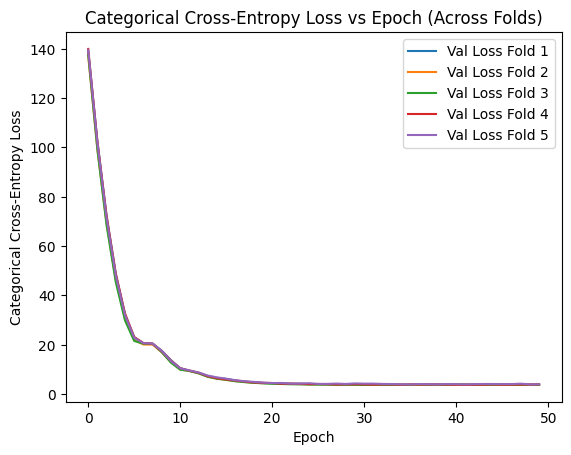

In [5]:
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_results = []
models_from_folds = []  # This list will store models from each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    # Define the model
    model = Sequential()
    model.add(Dense(128, input_dim=13690, activation='relu',
                    kernel_regularizer=regularizers.l1(0.01)))  # L1 regularization
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Output layer for 3 ordinal classes

    # Compile model (use SparseCategoricalCrossentropy if labels are integers 0/1/2)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train[train_idx], y_train[train_idx],
        epochs=50,
        batch_size=32,
        validation_data=(X_train[val_idx], y_train[val_idx]),
        verbose=1
    )

    fold_results.append(history.history)
    models_from_folds.append(model)

# Plot validation loss across all folds
for fold_idx, history in enumerate(fold_results):
    plt.plot(history['val_loss'], label=f'Val Loss Fold {fold_idx + 1}')
plt.title('Categorical Cross-Entropy Loss vs Epoch (Across Folds)')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.show()


Top Neutral Mass (Mass, Intensity): (None, None)


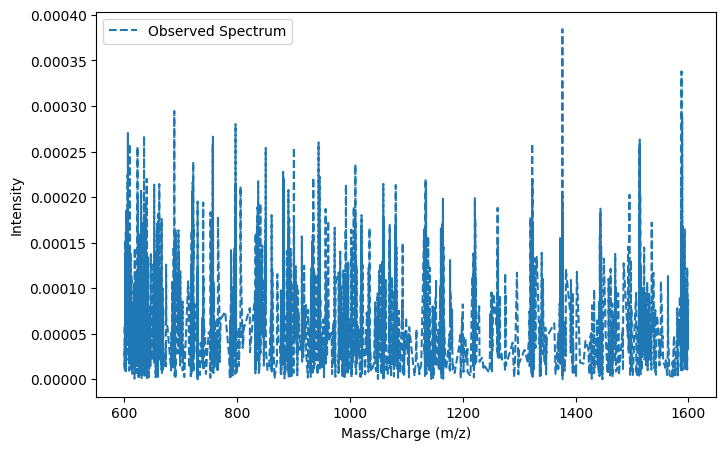

Top Neutral Mass (Mass, Intensity): (10402.000000000455, 0.0006115084397606552)


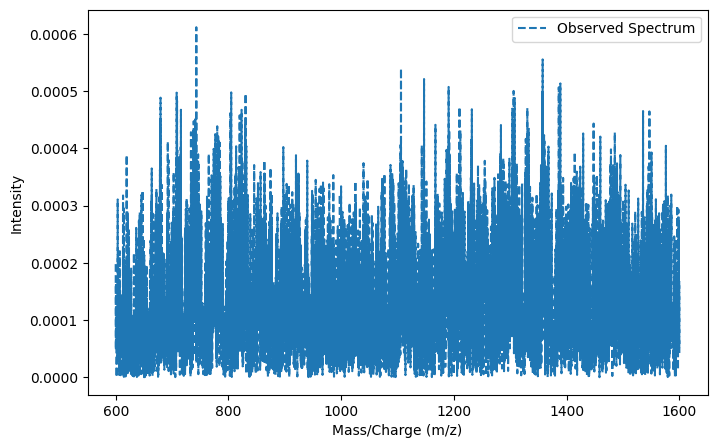

In [6]:
def compute_avg_logodds_gradient_for_pair(X: tf.Tensor, models: list, class_a: int, class_b: int, eps: float = 1e-8):
    """
    Average input gradient of log-odds log p(class_a|x) - log p(class_b|x) across samples and models.
    Assumes each model outputs softmax probabilities of shape (batch, 3).
    Returns a 1D tensor of shape (D,) with the averaged gradient.
    """
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    N, D = X.shape[0], X.shape[1]

    sample_grads = []
    for i in range(N):
        x_i = X[i:i+1]  # (1, D)
        grads_over_models = []

        for m in models:
            with tf.GradientTape() as tape:
                tape.watch(x_i)
                p = m(x_i, training=False)  # (1, 3) softmax probabilities
                log_odds = tf.math.log(p[:, class_a] + eps) - tf.math.log(p[:, class_b] + eps)  # (1,)
            g = tape.gradient(log_odds, x_i)  # (1, D)
            grads_over_models.append(tf.squeeze(g, axis=0))  # (D,)

        # average over models for this sample
        g_avg_models = tf.reduce_mean(tf.stack(grads_over_models, axis=0), axis=0)  # (D,)
        sample_grads.append(g_avg_models)

    # average over samples
    avg_grad = tf.reduce_mean(tf.stack(sample_grads, axis=0), axis=0)  # (D,)
    return avg_grad

# ===== Usage with your variables =====
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)

# Gradients for label 1 vs 0 and label 2 vs 0
avg_grad_1_vs_0 = compute_avg_logodds_gradient_for_pair(X_train_tensor, models_from_folds, class_a=1, class_b=0)
avg_grad_2_vs_0 = compute_avg_logodds_gradient_for_pair(X_train_tensor, models_from_folds, class_a=2, class_b=0)

# Map first 10,000 features to your x-grid [600, 1600) with 0.1 step (10,000 points)
x = np.arange(600, 1600, 0.1)  # length 10000

# --- Pair: 1 vs 0 ---
y_1_vs_0 = avg_grad_1_vs_0.numpy().flatten()[0:10000]

x_pos_1v0 = x[y_1_vs_0 > 0]
y_pos_1v0 = y_1_vs_0[y_1_vs_0 > 0]

x_neg_1v0 = x[y_1_vs_0 < 0]
y_neg_1v0 = y_1_vs_0[y_1_vs_0 < 0]

# --- Pair: 2 vs 0 ---
y_2_vs_0 = avg_grad_2_vs_0.numpy().flatten()[0:10000]

x_pos_2v0 = x[y_2_vs_0 > 0]
y_pos_2v0 = y_2_vs_0[y_2_vs_0 > 0]

x_neg_2v0 = x[y_2_vs_0 < 0]
y_neg_2v0 = y_2_vs_0[y_2_vs_0 < 0]



y_values = (y_neg_2v0)*-1
x_values = x_neg_2v0

mass_values, deconvoluted_spectrum, charge_mapping, top_peak = charge_state_deconvolution(x_values, y_values)

print("Top Neutral Mass (Mass, Intensity):", top_peak)

plot_raw_spectrum(x_values, y_values, charge_mapping)

y_values = y_pos_2v0
x_values = x_pos_2v0

mass_values, deconvoluted_spectrum, charge_mapping, top_peak = charge_state_deconvolution(x_values, y_values)

print("Top Neutral Mass (Mass, Intensity):", top_peak)

plot_raw_spectrum(x_values, y_values, charge_mapping)


In [10]:
import subprocess

my_dic = {'x': x_pos_2v0, 'y': x_pos_2v0}
df = pd.DataFrame(my_dic)
df.to_csv('F:/casts/positive20m.csv')

my_dic = {'x': x_neg_2v0, 'y': (y_neg_2v0)*-1}
df = pd.DataFrame(my_dic)
df.to_csv('F:/casts/negative20m.csv')


file_name = 'F:/casts/negative20m.csv'
command = f"python -m unidec -f {file_name}"
subprocess.run(command, shell=True)

CompletedProcess(args='python -m unidec -f F:/casts/negative20m.csv', returncode=1)